# Lab 3: ATLAS Data Analysis

## Important Constants and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# After completing the lab I am disappointed to see I typed these all in and did not need any of them
mZ = 91.1880 # GeV / c^2
dmZ = 0.0020 # GeV / c^2
mW = 80.3692 # GeV / c^2
dmW = 0.0133 # GeV / c^2
mH = 125.20 # GeV / c^2
dmH = 0.11 # GeV / c^2
me = 0.51099895000 # MeV / c^2
dme = 0.00000000015 # MeV / c^2
mmu = 105.6583755 # MeV / c^2
dmmu = 0.0000023 # MeV / c^2
mtau = 1776.93 # MeV / c^2
dmtau = 0.09 # MeV / c^2

## Part 1: The Invariant Mass Distribution

### Loading Data

In [2]:
data = np.loadtxt('atlas_z_to_ll.csv', delimiter = ',', skiprows = 1) # loading the data
pT1 = data[:,0] # creating an aray of pT1
pT2 = data[:,1] # creating an aray of pT2
eta1 = data[:,2] # creating an aray of eta1
eta2 = data[:,3] # creating an aray of eta2
phi1 = data[:,4] # creating an aray of phi1
phi2 = data[:,5] # creating an aray of phi2
E1 = data[:,6] # creating an aray of E1
E2 = data[:,7] # creating an aray of E2

### Calculating the components of p and using them to find M

In [3]:
px1 = pT1 * np.cos(phi1) # calculating px1
py1 = pT1 * np.sin(phi1) # calculating py1
pz1 = pT1 * np.sinh(eta1) # calculating pz1

px2 = pT2 * np.cos(phi2) # calculating px2
py2 = pT2 * np.sin(phi2) # calculating py2
pz2 = pT2 * np.sinh(eta2) # calculating pz2

px = px1 + px2 # calculating total px
py = py1 + py2 # calculating total py
pz = pz1 + pz2 # calculating total pz

M = np.sqrt((E1 + E2) ** 2 - (px ** 2 + py ** 2 + pz ** 2)) # calculating M

nn = (M > 87) & (M < 93)
M2 = M[nn]
print(np.average(M))
print(np.std(M))
print(len(M2)/len(M))

84.44980015640508
29.152951991966034
0.476


### Making a histogram of of the masses

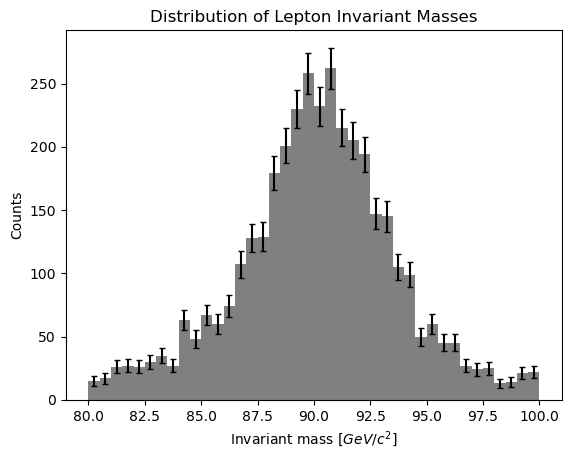

In [4]:
bins = np.linspace(80, 100, 41) # creating bins

fig, ax = plt.subplots() # making my fig and axes
n, bins, patch = ax.hist(M, bins = bins, color = 'grey') # making the histogram

bins_mid = (0.5) * (bins[0:-1] + bins[1:]) # finding the centers of the bins

err = np.sqrt(n) # calculating errors 

ax.errorbar(bins_mid, n, yerr = err, ls = '', color = 'black', capsize = 2) # plotting the errors
ax.set_xlabel(r'Invariant mass [$GeV/c^2$]') # setting the x label
ax.set_ylabel('Counts') # setting the y label
ax.set_title('Distribution of Lepton Invariant Masses'); # setting the title

## Part 2: Breit-Wigner Fit

### Fitting the data

In [5]:
def dist(m, m0, Gamma): # defining the function
    return 2500 * (1 / np.pi) * (Gamma / 2) / ((m - m0) ** 2 + (Gamma / 2) ** 2) # return the Breit-Wigner distribution

mask = (bins_mid > 87) & (bins_mid < 93) # making a mask

bins_mid_mask = bins_mid[mask] # applying the mask to my bins
n_mask = n[mask] # applying the mask to my number of items in the bins
err_mask = err[mask] # applying the mask to my errors

p0 = [90, 0.05] # starting point

params, covar = scipy.optimize.curve_fit(dist, bins_mid_mask, n_mask, sigma = err_mask, absolute_sigma = True) # fitting

fit_m0, fit_Gamma = params[0], params[1] # extracting and naming my paramters
dm0, dGamma = np.sqrt(covar[0][0]), np.sqrt(covar[1][1]) # extracting and naming my uncertainties

residuals = n_mask - dist(bins_mid_mask, *params) # calculating my residuals

full_residuals = n - dist(bins_mid, *params) # calculatign residuals for full range of bins

chisq = np.sum((residuals / err_mask) ** 2) # calculating chi squared
ndof = len(residuals) - 2 # calculating the number of degrees of freedom
red_chisq = chisq / ndof # calculating the reduced chi squared
p_val = scipy.stats.chi2.sf(chisq, ndof) # finding the p value

print(f'Chi squared = {chisq:.3f}') # printing the chi squared
print(f'NDOF = {ndof:.3f}') # printing the degrees of freedom
print(f'Reduced chi squared = {red_chisq:.3f}') # printing the reduced chi squared
print(f'p value = {p_val:.3f}') # printing the p value
print(f'm0 = {fit_m0:.3f} +/- {dm0:.3f} GeV/c^2') # pringing m0

Chi squared = 9.985
NDOF = 10.000
Reduced chi squared = 0.999
p value = 0.442
m0 = 90.341 +/- 0.094 GeV/c^2


### Plotting the fit and residuals

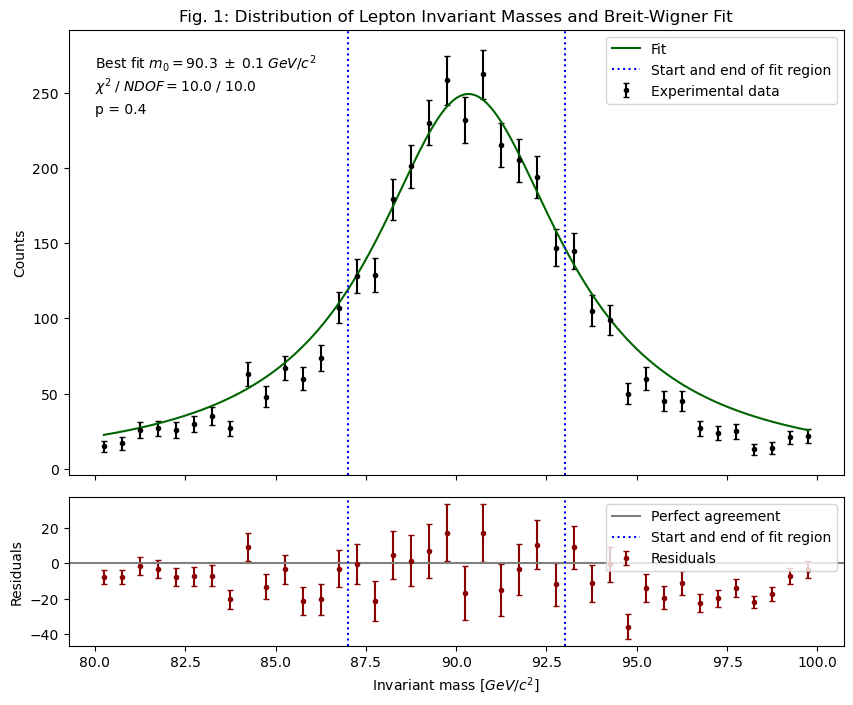

In [6]:
samples = np.linspace(min(bins_mid), max(bins_mid), 1000) # creating an array of samples to apply the fit to
model = dist(samples, *params) # applying the fit to the samples

fig, (ax, ax1) = plt.subplots(2, 1, sharex = True, figsize = (10, 8), gridspec_kw = {'height_ratios': [3,1], 'hspace': 0.075}) # making a fancy plot
# ax.hist(M, bins = bins, color = 'grey', label = 'Experimental data') # adding the histogram
ax.errorbar(bins_mid, n, yerr = err, ls = '', marker = 'o', markersize = 3, color = 'black', label = 'Experimental data', capsize = 2) # adding errorbars to the histogram
ax.plot(samples, model, label = 'Fit', color = 'darkgreen') # adding my fit
ax.axvline(x = 87, ls  =':', color = 'blue', label = 'Start and end of fit region') # adding line at the start of the fit
ax.axvline(x = 93, ls  =':', color = 'blue') # adding a line at the end of the fit

ax1.errorbar(bins_mid, full_residuals, err, ls = '', marker = 'o', markersize = '3', color = 'darkred', label = 'Residuals', capsize = 2) # adding the residuals
ax1.set_ylabel('Residuals') # setting my y label
ax1.axhline(y = 0, ls = '-', color = 'grey', label = 'Perfect agreement') # adding a perfect agreement line
ax1.axvline(x = 87, ls  =':', color = 'blue', label = 'Start and end of fit region') # adding line at the start of the fit
ax1.axvline(x = 93, ls  =':', color = 'blue') # adding a line at the end of the fit
ax1.legend(loc = 'upper right') # adding a legend

ax1.set_xlabel(r'Invariant mass [$GeV/c^2$]') # setting my main x label
ax.set_ylabel('Counts') # setting my main y label
ax.set_title('Fig. 1: Distribution of Lepton Invariant Masses and Breit-Wigner Fit') # setting my title
ax.legend(loc = 'upper right') # adding the main legend

ax.text(80, 266, r'Best fit $m_0 =$' f'{fit_m0:.1f}' r'$\; \pm \;$' f'{dm0:.1f}' r'$\; GeV/c^2$'); # annotation adding the m0 value
ax.text(80., 251, r'$\chi^2 \; / \; NDOF =$' f'{chisq:.1f} / {ndof:.1f}') # annotation adding the chi squared
ax.text(80, 236, f'p = {p_val:.1f}'); # annotation adding the p value
plt.savefig('Fig1.jpg', dpi = 750) # saving my figure

## Part 3: 2D Parameter Contours

### Creating the $\Delta \chi^2$ map

In [7]:
n_chisq = 300 # number of points on each axis for scanning
masses = np.linspace(89, 91, n_chisq) # making array of masses
widths = np.linspace(5, 8, n_chisq) # making array of widths
chi_map = np.zeros((n_chisq, n_chisq)) # making an n x n matrix of zeros for the chi squares

for i in range(n_chisq): # looping over the number of points
    for j in range(n_chisq): # looping over the number of points again
        theory = dist(bins_mid_mask, masses[i], widths[j]) # finding the theory based on the corresponding parameters
        chi2 = np.sum((theory - n_mask)**2/err_mask**2) # calculating chi squared based on that theory
        chi_map[j,i] = chi2 # adding that chi squared to the matrix of chi squares

chi_min = np.min(chi_map) # finding the lowest chi sqaure
chi_map = np.clip(chi_map, chi_min, chi_min + 35) # clipping the map at 35 units above the minimum
delta_chi_map = chi_map - chi_min # making a delta chi squared map

### Plotting map on a 2D contour plot

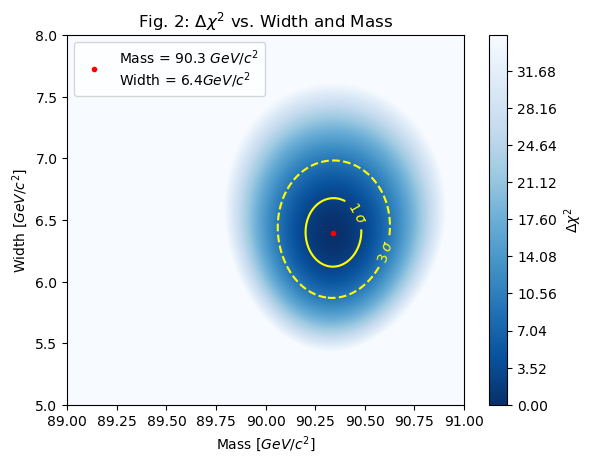

In [8]:
X, Y = np.meshgrid(masses, widths) # making a meshgrid of masses and widths
fig, ax = plt.subplots() # making my axes
cs = ax.contourf(masses, widths, delta_chi_map, 500, cmap = "Blues_r") # plotting the delta chi squares on a contour plot
cbar = fig.colorbar(cs, ax = ax) # adding the color bar
cbar.set_label(r'$\Delta \chi^2$') # setting the color bar label
ax.set_xlabel(r'Mass [$GeV/c^2$]') # setting the x label
ax.set_ylabel(r'Width [$GeV/c^2$]') # setting the y label
ax.set_title(r'Fig. 2: $\Delta \chi^2$ vs. Width and Mass') # setting the title
ax.plot(fit_m0, fit_Gamma, 'o', color = 'red', markersize = '3', label = f'Mass = {fit_m0:.1f} ' r'$GeV/c^2$' f' \nWidth = {fit_Gamma:.1f}' r'$GeV/c^2$') # plotting my best fit from part 2
ax.legend(loc = 'upper left') # adding a legend

levels = [2.3, 9.21] # defining my one sigma and three sigma levels
CS = ax.contour(X, Y, delta_chi_map, levels = levels, colors = ["yellow", "yellow"], linestyles = ["solid", "dashed"]) # adding the contours

fmt = {} # making an empty dictionary
strs = [r'$1 \; \sigma$', r'$3 \; \sigma$'] # creating a list of my label strings
for l, s in zip(CS.levels, strs): # adding those strings to the dictionary
    fmt[l] = s
ax.clabel(CS, CS.levels, fmt=fmt, fontsize=10); # plotting those strings as labels
plt.savefig('Fig2.jpg', dpi = 750) # saving my figure